In [ ]:
from google.colab import drive
import os

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tqdm
from scipy.spatial import KDTree
import ast
import seaborn as sns
import time
import os
from multiprocessing import Pool
import requests
import ast
from matplotlib.colors import LogNorm
import pickle
import scipy.sparse as sp
from scipy.signal import convolve2d
import gc

In [ ]:
os.chdir('/content/drive/MyDrive/BRI Analysis')

### Now do some plotting

In [ ]:
%run hist_functions.py
%run plot_functions.py

In [ ]:
inv_dir = "./data/bri_computations"
restrict = False
if restrict:
  restrict_suffix = "_restrict"
else:
  restrict_suffix = ""
output_file = f"./data/PDB727K_mean_invariants_by_chain{restrict_suffix}.csv"

In [ ]:
# 1. Delete the output file if it exists so we don't append to data from a previous run
if os.path.exists(output_file):
    os.remove(output_file)

# 2. Iterate and append
for i, filename in enumerate(tqdm.tqdm(os.listdir(inv_dir))):
    try:
        # Read the file
        inv_data = pd.read_parquet(os.path.join(inv_dir, filename))

        # Calculate means
        mean_data = calculate_means(inv_data)

        # 3. Write incrementally to CSV
        if i == 0:
            # First batch: Write 'w' (write) mode and include the header
            mean_data.to_csv(output_file, index=False, mode='w')
        else:
            # Subsequent batches: Write 'a' (append) mode and NO header
            mean_data.to_csv(output_file, index=False, mode='a', header=False)

        # 4. Explicitly free memory
        del inv_data
        del mean_data

        # Force garbage collection every 10 iterations to prevent fragmentation
        if i % 10 == 0:
            gc.collect()

    except Exception as e:
        print(f"Skipping {filename} due to error: {e}")

100%|██████████| 125/125 [05:11<00:00,  2.49s/it]


In [ ]:
# Reload so you don't have to compute means every time
mean_data_complete = pd.read_csv(f"./data/PDB727K_mean_invariants_by_chain{restrict_suffix}.csv")

mean_data_complete.head(5)

,pdb_id,model_id,chain_id,start_residue,chain_length,x(N),y(N),z(N),x(A),y(A),...,length(C),angle(N),angle(A),angle(C),x(AN),x(AC),y(AC),tau(NA),tau(AC),tau(CN)
0,101M,1,A,1,154,0.507857,0.843773,0.504091,-0.460130,1.369578,...,1.528591,121.467974,111.773506,116.730654,1.459409,-0.566500,1.418442,71.471438,45.858889,178.831176
1,102L,1,A,1,163,0.299411,0.755528,0.363061,-0.489699,1.346994,...,1.518583,120.861790,111.773620,116.244444,1.450595,-0.562669,1.408626,76.388025,59.042778,178.002654
2,102M,1,A,1,154,0.516649,0.844338,0.496481,-0.461961,1.370097,...,1.526019,121.328693,111.745455,116.707778,1.460481,-0.564812,1.416182,71.856797,45.481307,178.952614
3,103M,1,A,1,154,0.506779,0.840032,0.501766,-0.454675,1.370136,...,1.527643,121.566471,111.732338,116.677386,1.458461,-0.565104,1.417922,71.593725,46.198954,178.862026
4,104L,1,A,1,164,0.268817,0.705311,0.370591,-0.467122,1.341689,...,1.511116,120.845951,111.443171,115.362945,1.446171,-0.551817,1.403348,74.457055,61.607730,177.827485


In [ ]:
# @title Get meta data and corresponding pdb_ids

meta_data = pd.read_csv('./data/PDB727K_webscrape_meta_data.csv')

#restrict to XRD only and then restrict to resolutions leq 2A
meta_data_xrd = meta_data[meta_data['Method']=='X-RAY DIFFRACTION'].copy()

# 1. Strip the brackets
# '[2.55]'      -> '2.55'
clean_step_1 = meta_data_xrd['Resolution'].astype(str).str.strip('[]')

# 2. Split by comma and take the first element
clean_step_2 = clean_step_1.str.split(',').str[0]

# 3. Convert to numeric
# This will handle the string '2.0' turning into float 2.0
# It also turns empty strings '' into NaN
meta_data_xrd['Resolution'] = pd.to_numeric(clean_step_2, errors='coerce')

meta_data_xrd_lt_2A = meta_data_xrd[meta_data_xrd['Resolution']<=2].copy()
pdb_ids_lt_2A = meta_data_xrd_lt_2A['pdb_id'].unique()

### Standard heatmaps

In [ ]:
#check this is doing all the correct pdb_ids

Processing factor: length(N)


Pass 2 (Outliers): length(N): 100%|██████████| 134/134 [01:24<00:00,  1.58it/s]


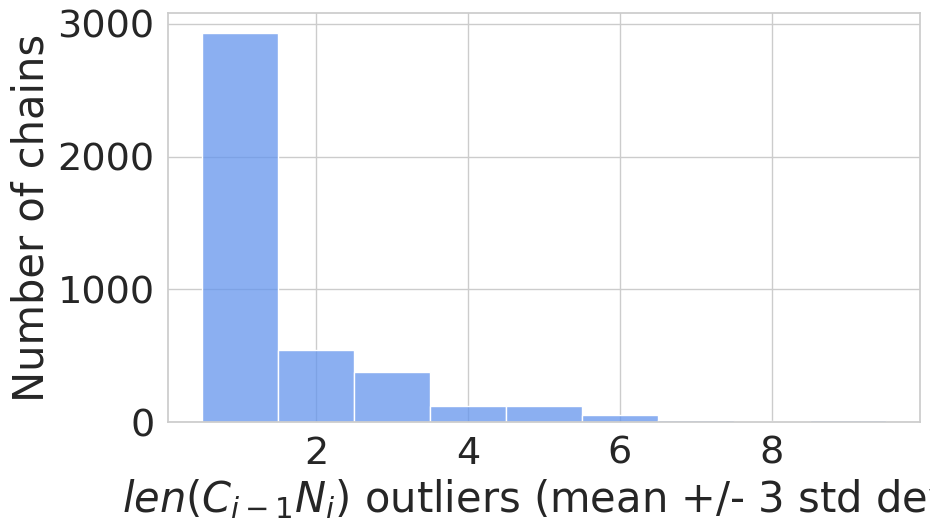

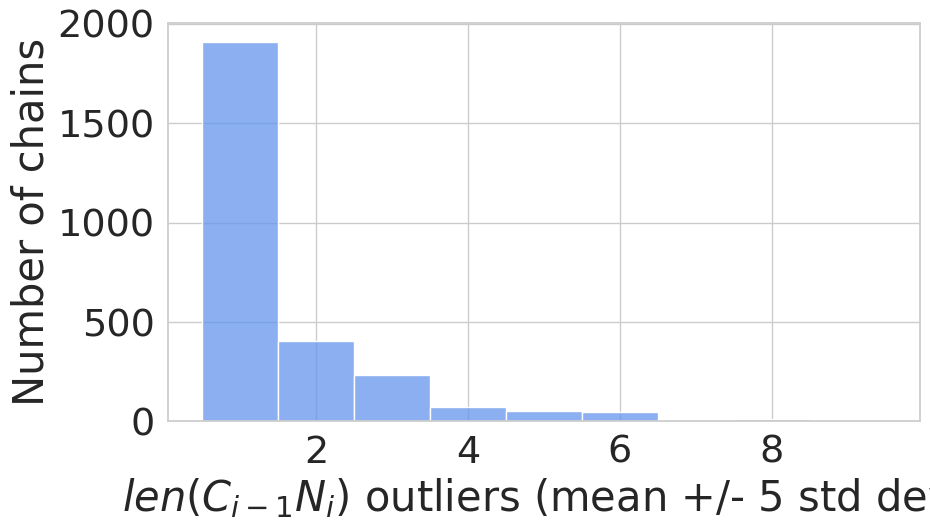

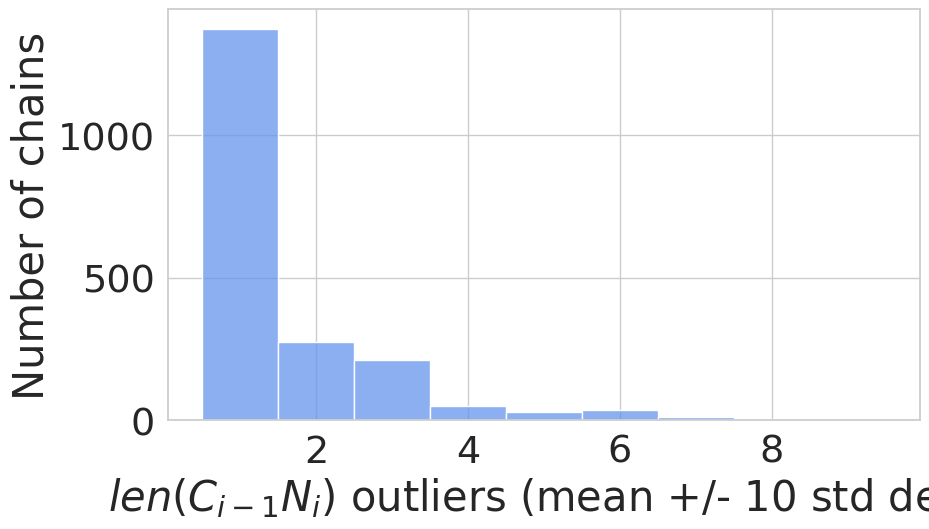

Processing factor: length(A)


Pass 2 (Outliers): length(A): 100%|██████████| 134/134 [01:34<00:00,  1.41it/s]


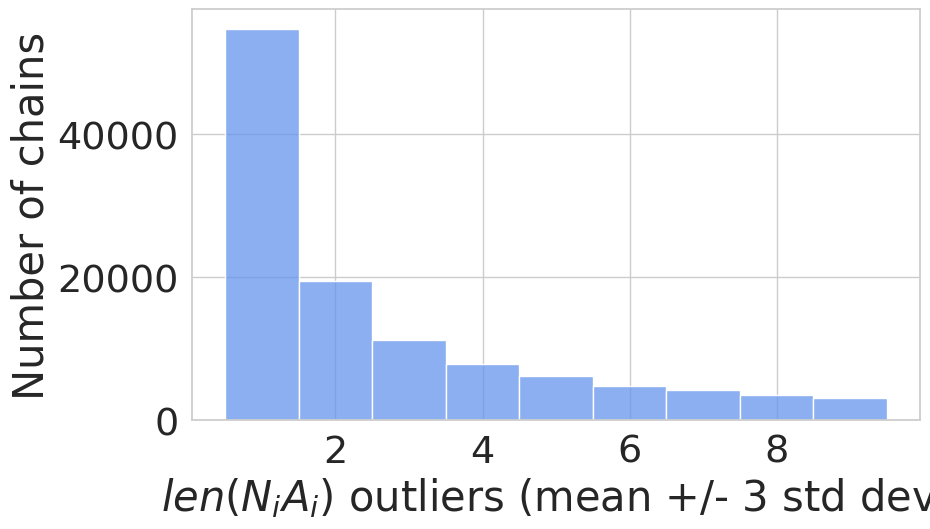

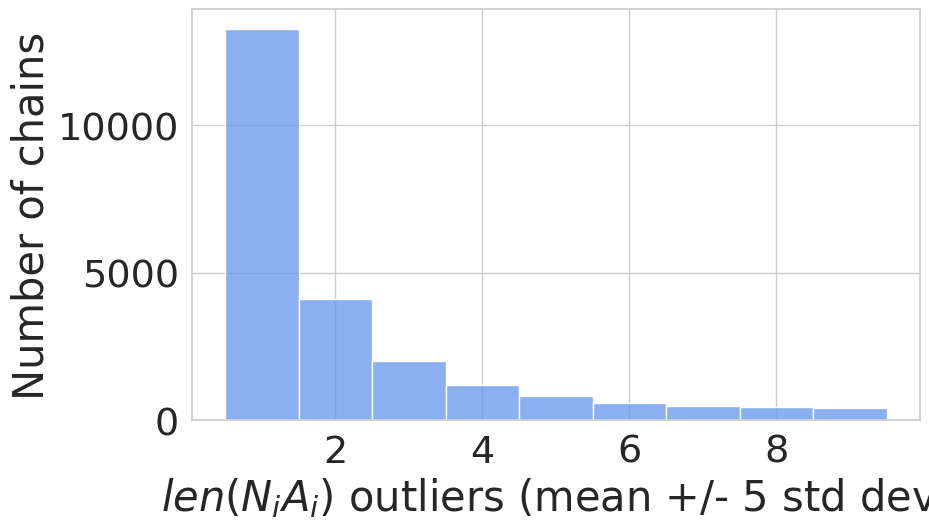

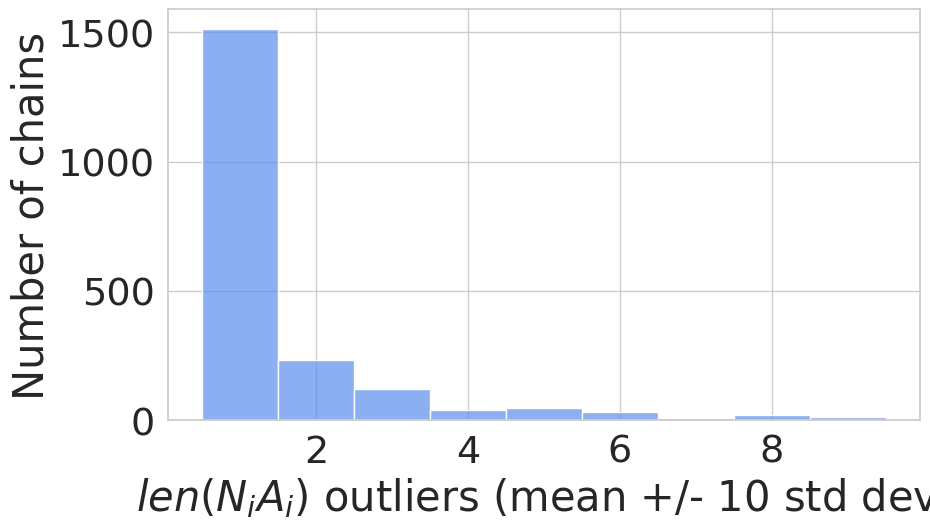

Processing factor: length(C)


Pass 2 (Outliers): length(C): 100%|██████████| 134/134 [01:34<00:00,  1.42it/s]


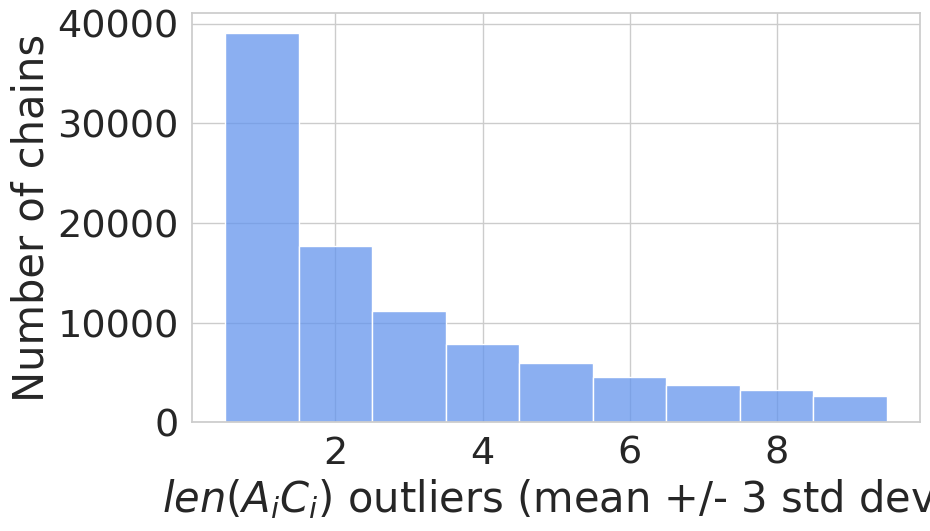

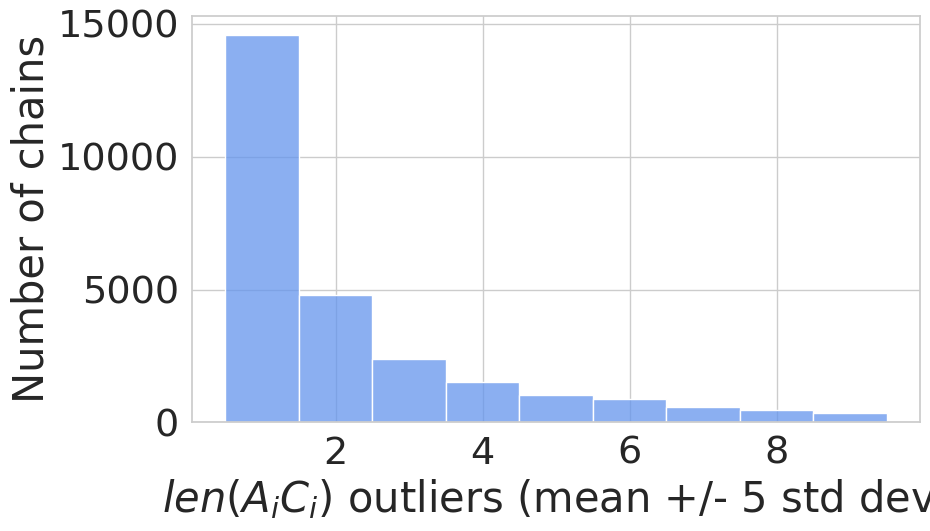

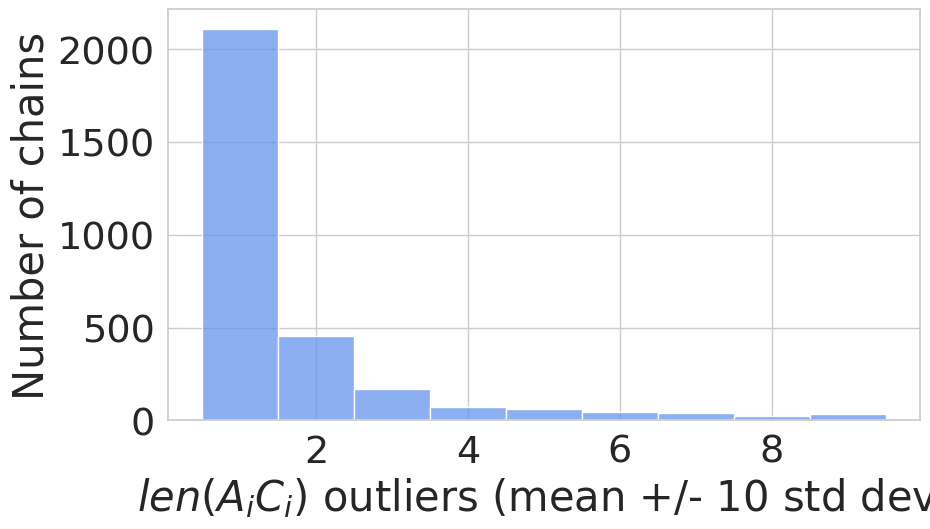

Processing factor: angle(N)


Pass 2 (Outliers): angle(N): 100%|██████████| 134/134 [01:36<00:00,  1.39it/s]


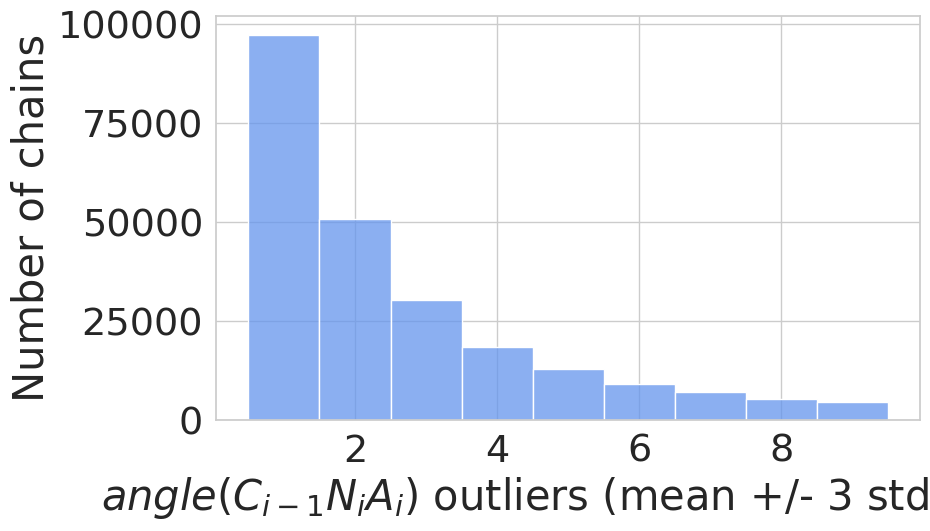

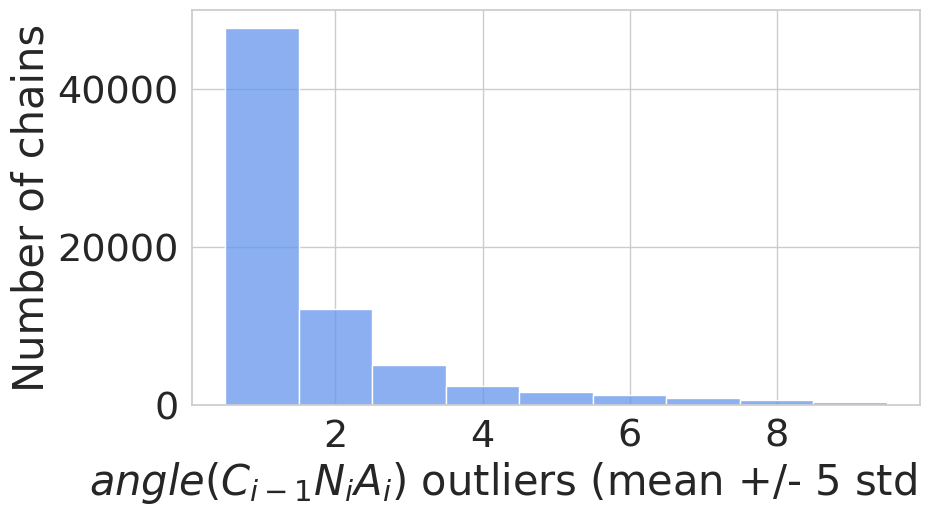

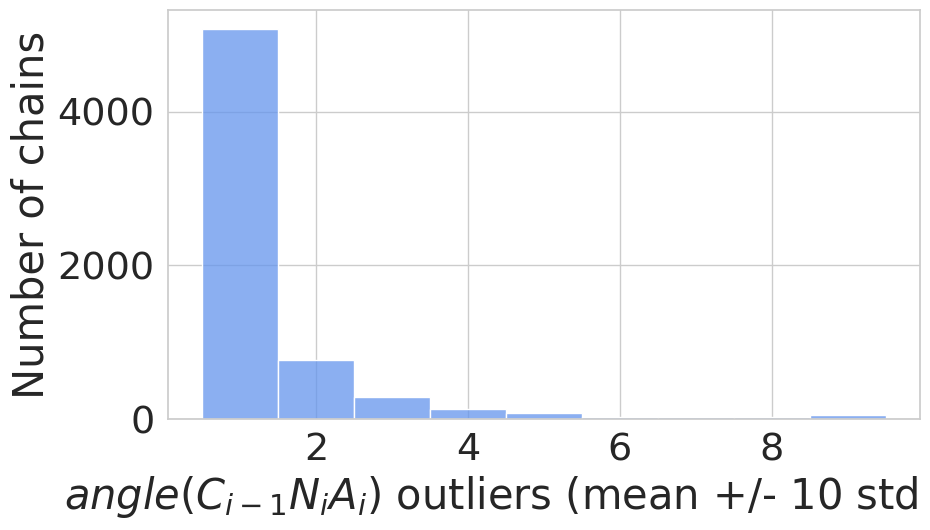

Processing factor: angle(A)


Pass 2 (Outliers): angle(A): 100%|██████████| 134/134 [01:56<00:00,  1.15it/s]


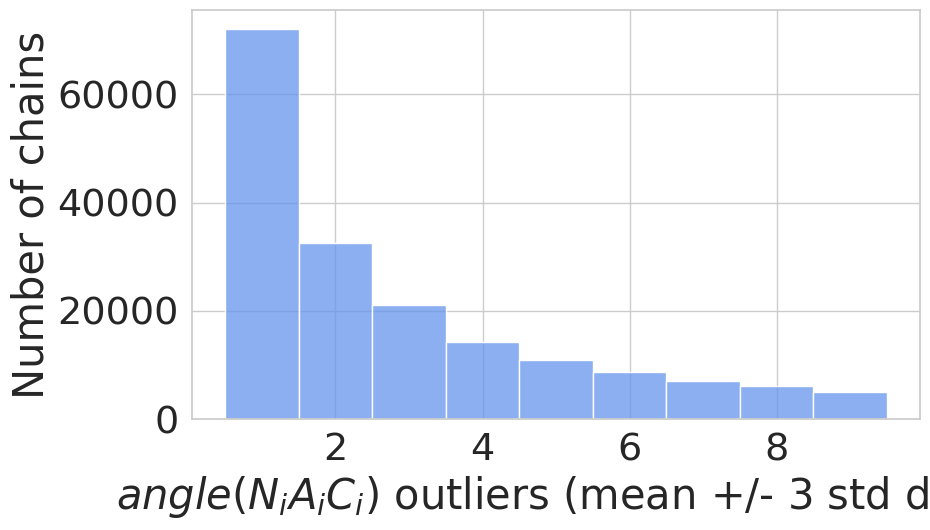

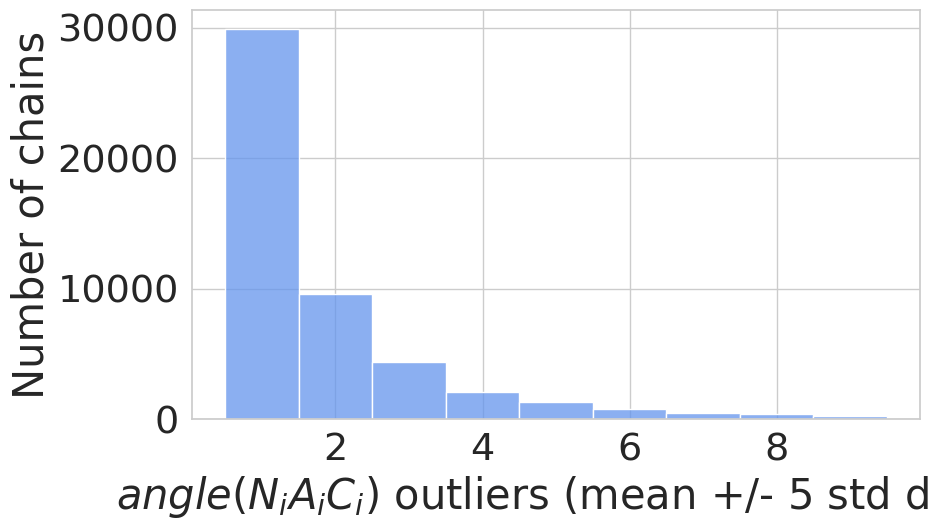

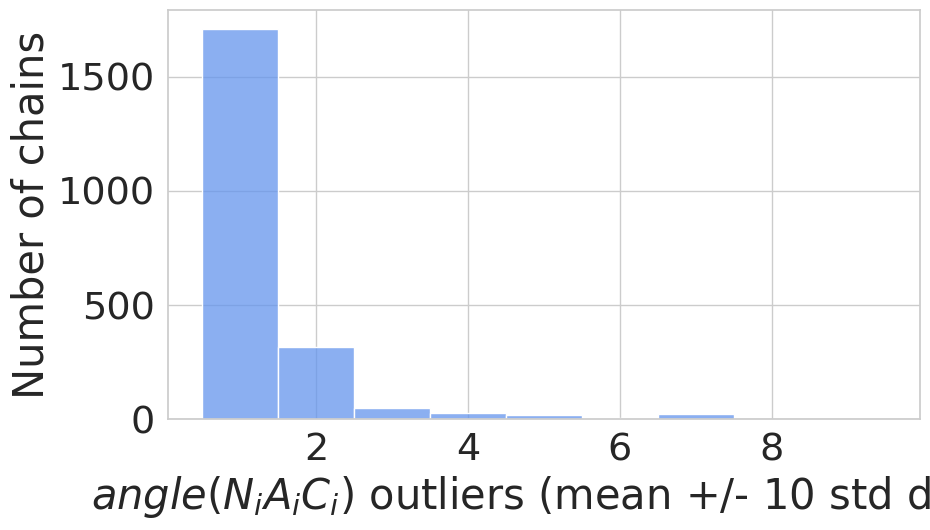

Processing factor: angle(C)


Pass 2 (Outliers): angle(C): 100%|██████████| 134/134 [01:34<00:00,  1.41it/s]


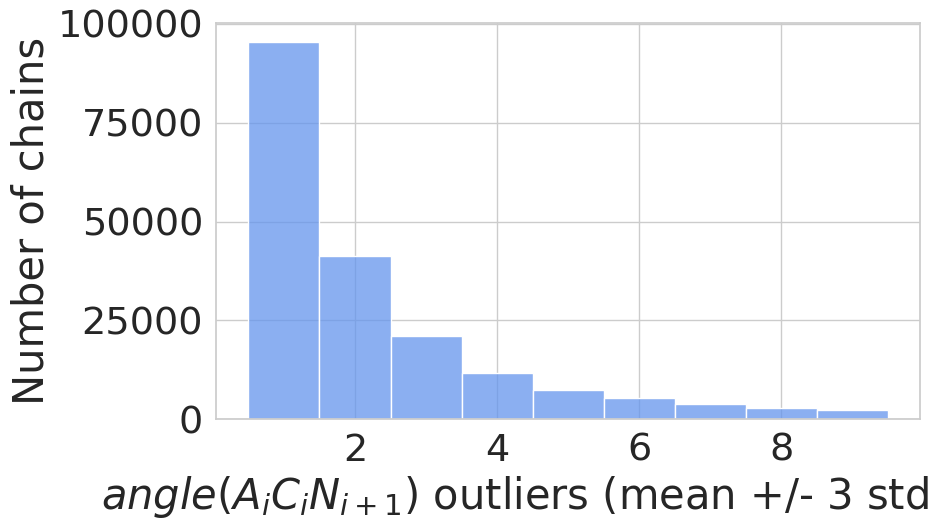

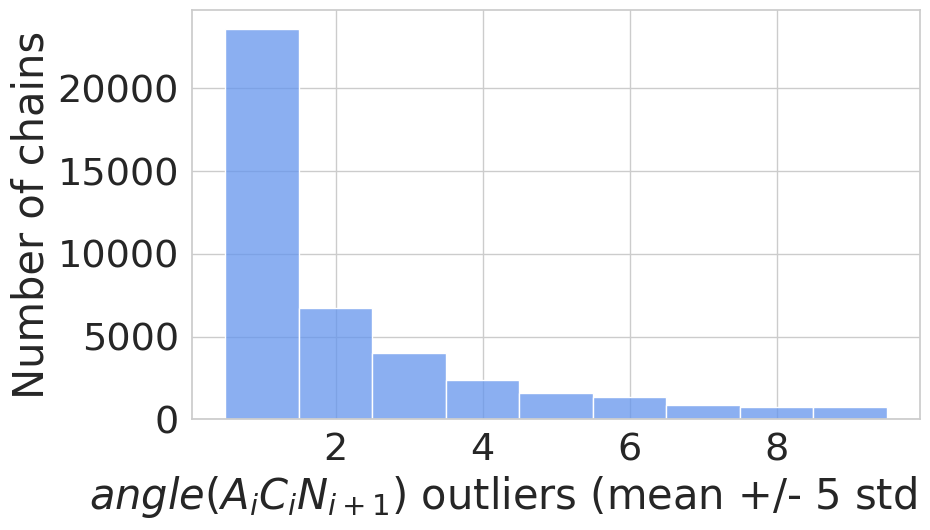

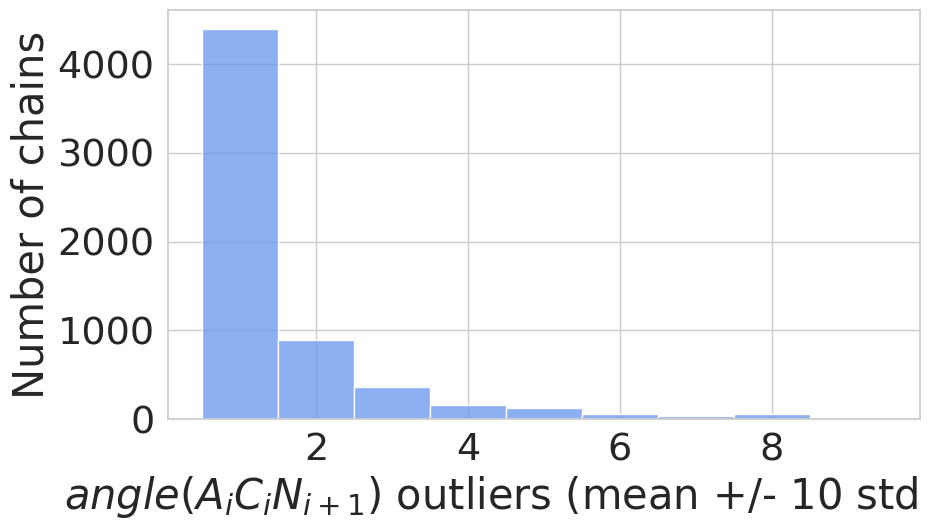

In [ ]:
import os
import pandas as pd
import numpy as np
import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import math

# Configuration
if not os.path.exists(f'./data/outliers_per_chain{restrict_suffix}'):
    os.makedirs(f'./data/outliers_per_chain{restrict_suffix}')

output_descriptors = []
factors = ['length(N)', 'length(A)', 'length(C)', 'angle(N)', 'angle(A)', 'angle(C)']
factors_latex = ['$len(C_{i-1}N_{i})$', '$len(N_{i}A_{i})$', '$len(A_{i}C_{i})$',
                 '$angle(C_{i-1}N_{i}A_{i})$', '$angle(N_{i}A_{i}C_{i})$', '$angle(A_{i}C_{i}N_{i+1})$']
sds_to_plot = [3, 5, 10]

# Pre-filter file list if restricting
all_files = os.listdir(inv_dir)
# Note: If 'restrict' logic depends on opening the file to check PDB ID, we must do it inside the loop.
# Assuming we process all files in directory for now, filtering inside as per your snippet.

for j in range(len(factors)):
    factor = factors[j]
    factor_latex = factors_latex[j]

    print(f"Processing factor: {factor}")

    # ==============================================================================
    # PASS 1: Calculate Global Mean and Standard Deviation without crashing RAM
    # ==============================================================================
    total_count = 0
    total_sum = 0.0
    total_sum_sq = 0.0

    # We need to compute global stats first
    for i in tqdm.tqdm(all_files, desc=f"Pass 1 (Stats): {factor}"):
        try:
            # Only load necessary columns for stats
            df = pd.read_parquet(os.path.join(inv_dir, i), columns=['pdb_id', factor])

            if restrict:
                df = df[df['pdb_id'].isin(pdb_ids_lt_2A)]

            # dropna is crucial for accurate stats
            series = df[factor].dropna()

            if not series.empty:
                count = len(series)
                total_count += count
                total_sum += series.sum()
                total_sum_sq += (series ** 2).sum()
        except Exception as e:
            continue

    if total_count == 0:
        print(f"No data found for {factor}")
        continue

    # Calculate global stats from aggregated sums
    global_mean = total_sum / total_count
    # Variance = (Sum_sq - (Sum^2)/N) / (N-1)
    global_var = (total_sum_sq - (total_sum**2 / total_count)) / (total_count - 1)
    global_std = math.sqrt(global_var)

    # Store descriptor data immediately
    # Note: Approximating median as mean here because calculating exact median
    # requires sorting the whole dataset (memory intensive).
    output_descriptors.append({
        'variable': factor,
        'mean': global_mean,
        'stdev': global_std,
        # Add other stats based on global_mean/std as needed
        'mean_plus_one_sd': global_mean + global_std,
        'mean_minus_one_sd': global_mean - global_std,
        'mean_plus_three_sd': global_mean + 3*global_std,
        'mean_minus_three_sd': global_mean - 3*global_std,
        'mean_plus_five_sd': global_mean + 5*global_std,
        'mean_minus_five_sd': global_mean - 5*global_std,
        'mean_plus_ten_sd': global_mean + 10*global_std,
        'mean_minus_ten_sd': global_mean - 10*global_std,
    })

    # ==============================================================================
    # PASS 2: Count Outliers per Chain (Streaming)
    # ==============================================================================

    # We will collect counts for ALL SD thresholds in a single pass to save time
    # structure: {3: [df_counts_batch1, df_counts_batch2...], 5: [...], 10: [...]}
    batch_counts = {sd: [] for sd in sds_to_plot}

    cols_to_load = ['pdb_id', 'chain_id', 'model_id', 'start_residue', 'chain_length', factor]
    # Note: 'entity_id' was in your groupby but missing from your read_columns. Added it here.
    # If it's not in the parquet, remove it from cols_to_load and the groupby below.

    for i in tqdm.tqdm(all_files, desc=f"Pass 2 (Outliers): {factor}"):
        try:
            df = pd.read_parquet(os.path.join(inv_dir, i), columns=cols_to_load)

            if restrict:
                df = df[df['pdb_id'].isin(pdb_ids_lt_2A)]

            # For each SD threshold, count outliers in this batch
            for sd in sds_to_plot:
                upper = global_mean + sd * global_std
                lower = global_mean - sd * global_std

                # Identify outliers
                # We create a temporary boolean series
                is_outlier = ((df[factor] > upper) | (df[factor] < lower)).astype(int)

                if is_outlier.sum() > 0:
                    # We create a mini dataframe of just keys and the outlier count
                    # This is TINY compared to the full dataframe
                    batch_df = df[['pdb_id', 'chain_id', 'model_id', 'start_residue', 'chain_length']].copy()
                    batch_df['outlier'] = is_outlier

                    # Group by chain within this file
                    counts = batch_df.groupby(['pdb_id', 'chain_id', 'model_id', 'start_residue', 'chain_length'])['outlier'].sum().reset_index()

                    # Store only the counts
                    batch_counts[sd].append(counts)

        except Exception as e:
            # Handle missing columns or empty files gracefully
            continue

    # ==============================================================================
    # PLOTTING
    # ==============================================================================
    for sd in sds_to_plot:
        if not batch_counts[sd]:
            print(f"No outliers found for {factor} at {sd} SD")
            continue

        # Concatenate the small count dataframes
        final_counts_df = pd.concat(batch_counts[sd])

        # Group again in case a chain was split across files (unlikely but safe)
        final_counts_per_chain = final_counts_df.groupby(['pdb_id', 'chain_id', 'model_id', 'start_residue', 'chain_length'])['outlier'].sum().reset_index()

        # Create the histogram
        plt.figure(figsize=(10, 6))
        sns.set(font_scale=2.5)
        sns.set_style("whitegrid")

        sns.histplot(x='outlier', data=final_counts_per_chain, color='cornflowerblue', bins=np.arange(0.5, 10.5, 1))

        plt.xlabel(f'{factor_latex} outliers (mean +/- {str(sd)} std dev)')
        plt.ylabel('Number of chains')
        plt.tight_layout()

        plt.savefig(f'./data/outliers_per_chain{restrict_suffix}/PDB727K_outliers_outside_{str(sd)}_sd_of_mean_{factor}_gt1.PNG',
                    facecolor='white', transparent=False, bbox_inches="tight")
        plt.show()
        plt.close() # Close figure to free memory

# Save descriptors at the end
descriptor_data = pd.DataFrame(output_descriptors)
descriptor_data.to_csv('./data/PDB727K_length_and_angle_outlier_statistics.csv', index=False)

In [ ]:
descriptor_data

,variable,mean,stdev,mean_plus_one_sd,mean_minus_one_sd,mean_plus_three_sd,mean_minus_three_sd,mean_plus_five_sd,mean_minus_five_sd,mean_plus_ten_sd,mean_minus_ten_sd
0,length(N),1.330885,0.061653,1.392538,1.269232,1.515844,1.145926,1.639150,1.022620,1.947415,0.714355
1,length(A),1.459696,0.012436,1.472132,1.447260,1.497005,1.422388,1.521877,1.397515,1.584058,1.335335
2,length(C),1.524141,0.011811,1.535953,1.512330,1.559575,1.488707,1.583198,1.465085,1.642255,1.406028
3,angle(N),121.720635,1.731414,123.452049,119.989221,126.914878,116.526393,130.377706,113.063564,139.034778,104.406493
4,angle(A),111.018889,2.370175,113.389064,108.648714,118.129415,103.908364,122.869765,99.168013,134.720641,87.317137
5,angle(C),116.733154,1.322465,118.055619,115.410690,120.700548,112.765760,123.345478,110.120831,129.957801,103.508507


In [ ]:
import os
import pandas as pd
import tqdm
import numpy as np

# 1. Load Statistics and Pre-process Metadata
# We create a lookup dictionary so we don't need to query the DataFrame inside the loop
descriptor_data = pd.read_csv('./data/PDB727K_length_and_angle_outlier_statistics.csv')
stats_map = {}

for _, row in descriptor_data.iterrows():
    variable = row['variable']
    stats_map[variable] = {
        'mean': row['mean'],
        'sd': row['stdev'],
        'is_len': variable.startswith('len')
    }

factors = list(stats_map.keys())

# Define columns to read (Identifiers + All Factors)
# Ensure we include all columns required for the groupby
groupby_cols = ['pdb_id', 'chain_id', 'model_id', 'start_residue', 'chain_length']
# Note: Added 'entity_id' just in case, though it's not in the groupby keys below
read_cols = list(set(groupby_cols + factors))

accumulated_results = []

# 2. Iterate through files ONCE
files = os.listdir(inv_dir)

for file in tqdm.tqdm(files, desc="Processing files"):
    try:
        # Read all necessary columns at once
        data = pd.read_parquet(os.path.join(inv_dir, file), columns=read_cols)

        # Apply restriction if needed
        if restrict:
            data = data[data['pdb_id'].isin(pdb_ids_lt_2A)]
            if data.empty:
                continue

        # Initialize dictionary for aggregation: {output_col: (input_col, func)}
        # We calculate 'total_count' once using the first factor (size is the same for all)
        agg_def = {'total_count': (factors[0], 'size')}

        # 3. Process all factors using vectorized operations
        for factor in factors:
            stats = stats_map[factor]
            mean_ = stats['mean']
            sd_ = stats['sd']

            # Create boolean masks for this factor
            # We assign them to the DataFrame temporarily so groupby can see them

            # Standard Deviations
            data[f'{factor}_3sd'] = (data[factor] < mean_ - 3*sd_) | (data[factor] > mean_ + 3*sd_)
            data[f'{factor}_5sd'] = (data[factor] < mean_ - 5*sd_) | (data[factor] > mean_ + 5*sd_)
            data[f'{factor}_10sd'] = (data[factor] < mean_ - 10*sd_) | (data[factor] > mean_ + 10*sd_)

            # Fixed Thresholds (Length vs Angle)
            if stats['is_len']:
                data[f'{factor}_1'] = (data[factor] < mean_ - 0.05) | (data[factor] > mean_ + 0.05)
                data[f'{factor}_2'] = (data[factor] < mean_ - 0.1) | (data[factor] > mean_ + 0.1)
            else:
                data[f'{factor}_1'] = (data[factor] < mean_ - 1) | (data[factor] > mean_ + 1)
                data[f'{factor}_2'] = (data[factor] < mean_ - 5) | (data[factor] > mean_ + 5)

            # Add to aggregation dictionary
            # Key = Output Column Name, Value = (Temporary Column Name, Function)
            agg_def[f'{factor}_outlier_count_3sd'] = (f'{factor}_3sd', 'sum')
            agg_def[f'{factor}_outlier_count_5sd'] = (f'{factor}_5sd', 'sum')
            agg_def[f'{factor}_outlier_count_10sd'] = (f'{factor}_10sd', 'sum')
            agg_def[f'{factor}_outlier_count_1'] = (f'{factor}_1', 'sum')
            agg_def[f'{factor}_outlier_count_2'] = (f'{factor}_2', 'sum')

        # 4. GroupBy and Aggregate
        # We aggregate all factors simultaneously for the chains in this file
        batch_result = data.groupby(groupby_cols).agg(**agg_def).reset_index()

        accumulated_results.append(batch_result)

    except Exception as e:
        print(f"Skipping {file} due to error: {e}")
        continue

# 5. Concatenate and Save
if accumulated_results:
    total_results = pd.concat(accumulated_results, ignore_index=True)
    total_results.to_csv('./data/PDB727K_chains_number_of_outliers.csv', index=False)
    print("Processing complete. Saved to CSV.")
else:
    print("No data processed.")

Processing files: 100%|██████████| 136/136 [01:57<00:00,  1.16it/s]


Processing complete. Saved to CSV.
